# Introduction

The purpose of this notebook is to test the accuracy of circumcentric vs. barycentric formulations of DDG. But first we try to establish the simplest test case possible in 1D and the extend this to N-D problems.


#### 1D Analytical solutions

Consider the following functions and their differentials:
>The linear function $f_l = x_1$ it has the simple differential  $\nabla f_l = [1]$

>The parabolic function $f_p = x_1^2$ it has the simple differential $\nabla f_p = [2x_1]$

>The bi-quadratic polynomial function $f_q = x_1^4$ it has the simple differential $\nabla f_q = [4 x_1^3]$

Integrating by the boundaries of the domain [-0.5, 0,5]

>$\int^{0.5}_{-0.5}\nabla f_l = f_l(0.5) - f_l(-0.5) = 1.0 $

>$\int^{0.5}_{-0.5}\nabla f_p = f_p(0.5) - f_p(-0.5) = 0.0 $

>$\int^{0.5}_{-0.5}\nabla f_q = f_q(0.5) - f_q(-0.5) = 0.0 $

#### 2D Analytical solutions


The linear function $f_l = a x_1 + b x_2$ has the gradient potential $\sqrt{a^2 + b^2} * A$


#### N-D Analytical solutions





In [1]:
import numpy as np
def f_l(x):
    return np.sum(x)

def df_l_1d(x):
    return 1

def f_p(x):
    return np.sum(x**2)

def df_p_1d(x):
    return 2 * x

def f_q(x):
    return np.sum(x**4)

def df_q_1d(x):
    return 4 * x**3

In [2]:
f_q(0.5) - f_q(-0.5)

0.0

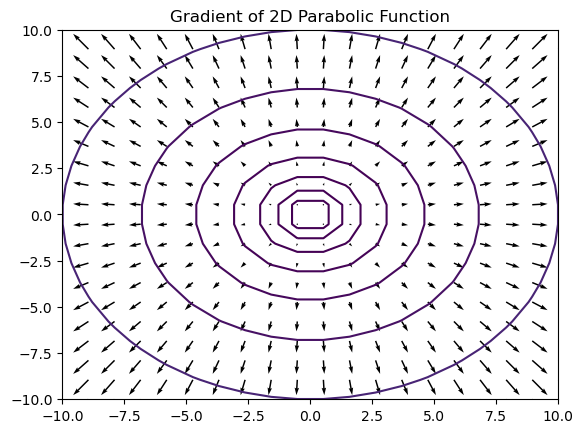

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function
def f(x, y):
    return x ** 2 + y ** 2

# Gradient of the function
def gradient(x, y):
    df_dx = 2 * x
    df_dy = 2 * y
    return df_dx, df_dy

# Create grid of points
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)

# Calculate function values
Z = f(X, Y)

# Calculate gradients
U, V = gradient(X, Y)

fig, ax = plt.subplots()

# Plot function
ax.contour(X, Y, Z, levels=np.logspace(0, 3, 10))

# Plot gradient vectors
ax.quiver(X, Y, U, V)

ax.set_title('Gradient of 2D Parabolic Function')
plt.show()


In [4]:
from scipy.integrate import dblquad
import numpy as np

# Function
def f(x, y):
    return x ** 2 + y ** 2

# Gradient of the function
def gradient(x, y):
    df_dx = 2 * x
    df_dy = 2 * y
    return df_dx, df_dy

# Gradient magnitude
def gradient_magnitude(x, y):
    df_dx, df_dy = gradient(x, y)
    return np.sqrt(df_dx**2 + df_dy**2)

# Define limits for integral
x_lower = -0.5
x_upper = 0.5
y_lower = -0.5
y_upper = 0.5

# Integrate over the region
result, error = dblquad(gradient_magnitude, x_lower, x_upper, lambda x: y_lower, lambda x: y_upper)

print("The integrated gradient potential over the unit square is:", result)


The integrated gradient potential over the unit square is: 0.7651957164640468


# Test DDG formulations

1. Circumcentric dual

See details in paper and ddgclib code snippets below

2. Barycentric dual

3. 

# Spherical cap


In [5]:
## Imports and physical parameters
# std library
import numpy as np
import scipy

# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ddgclib import *
#from ddgclib._case1 import *
from hyperct import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._eos import *
from ddgclib._misc import *
#from ddgclib._plotting import *

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
#rho_0 = eos(P=P_0, T=T_0)  # kg/m3, densi
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Capillary rise parameters
r = 2.0  # m, radius of the tube
theta_p = 0 * np.pi/180.0  # Three phase contact angle
theta_p = 20 * np.pi/180.0  # Three phase contact angle
theta_p = 50 * np.pi/180.0  # Three phase contact angle

def distance_matrix(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def cotan(theta):
    return 1 / np.tan(theta)


In [6]:
F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=4, refinement=0, cdist=1e-10, equilibrium=True)

In [7]:
HC.dim

3

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


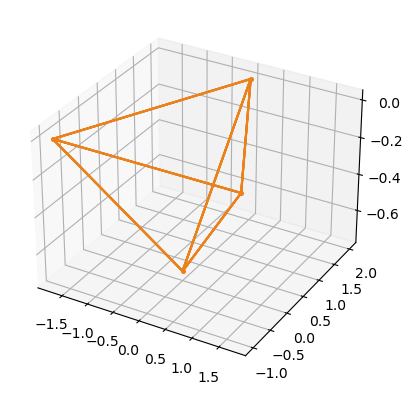

In [8]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
HC.plot_complex()
plt.show()

In [10]:
plot_polyscope(HC)

NameError: name 'plot_polyscope' is not defined

In [ ]:
HC.V.print_out()

In [11]:
help(HC.plot_complex)

Help on method plot_complex in module ddgclib._complex:

plot_complex(show=True, directed=True, complex_plot=True, contour_plot=True, surface_plot=True, surface_field_plot=True, minimiser_points=True, point_color='do', line_color='do', complex_color_f='lo', complex_color_e='do', pointsize=7, no_grids=False, save_fig=True, strpath=None, plot_path='fig/', fig_name='complex.pdf', arrow_width=None, fig_surface=None, ax_surface=None, fig_complex=None, ax_complex=None) method of ddgclib._complex.Complex instance
    Plots the current simplicial complex contained in the class. It requires
    at least one vector in the self.V to have been defined.
    
    
    :param show: boolean, optional, show the output plots
    :param directed: boolean, optional, adds directed arrows to edges
    :param contour_plot: boolean, optional, contour plots of the field functions
    :param surface_plot: boolean, optional, a 3 simplicial complex + sfield plot
    :param surface_field_plot: boolean, optional, 3

In [12]:
ax_complex = HC.plot_complex()

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


In [ ]:
ax_complex[0].show()

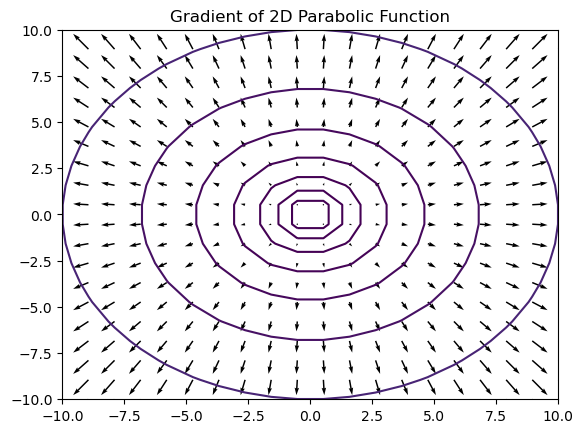

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function
def f(x, y):
    return x ** 2 + y ** 2

# Gradient of the function
def gradient(x, y):
    df_dx = 2 * x
    df_dy = 2 * y
    return df_dx, df_dy

# Create grid of points
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)

# Calculate function values
Z = f(X, Y)

# Calculate gradients
U, V = gradient(X, Y)

fig, ax = plt.subplots()

# Plot function
ax.contour(X, Y, Z, levels=np.logspace(0, 3, 10))

# Plot gradient vectors
ax.quiver(X, Y, U, V)

ax.set_title('Gradient of 2D Parabolic Function')
plt.show()
